In [3]:
import pandas as pd
import pandas_profiling as ppf
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100000
pd.options.display.max_columns = 100000
from datetime import datetime 
import numpy as np
import os, random, math, time
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

#preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.utils.multiclass import type_of_target
from scipy.stats import randint

#score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from math import sqrt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from lifelines.utils import k_fold_cross_validation

#modeling
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.evaluate import PredefinedHoldoutSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostClassifier
from lifelines import CoxPHFitter, AalenAdditiveFitter, WeibullAFTFitter, LogLogisticAFTFitter, LogNormalAFTFitter
from lifelines import GeneralizedGammaRegressionFitter
from lifelines.datasets import load_rossi
from lifelines.utils import find_best_parametric_model

#tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
def read_file(filename):
    df = pd.read_csv(f'{filename}', encoding="utf-8") #"cp949"
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def read_file2(filename):
    df = pd.read_excel(f'{filename}', header=None)
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def check_NA(df):
    print(f"NA check")
    NA_res = df.isna().sum()
    if NA_res.sum() != 0:
        for idx, i in enumerate(NA_res):
            if i != 0:
                print(df.columns[idx],i,"->",round(i/df.shape[0]*100,3),"%")
    else:
        print("...There's no NA")

In [5]:
log_data1 = read_file('Data/log_merge1_v2.csv')
log_data2 = read_file('Data/log_merge2_v2.csv')
doll_info = read_file('Data/merge_v5.csv')

...There are no duplicates
shape: (521214, 15)
...There are no duplicates
shape: (414600, 24)
...There are no duplicates
shape: (3182, 46)


# Preprocessing

음수 0 처리

In [4]:
change_list1 = ['stroke', 'hand_hold', 'knock', 'gymnastics', 'brain_timer']
change_list2 = ['stroke', 'hand_hold', 'knock', 'gymnastics_x', 'brain_timer', 'story', 'religion', 'music', 'english', 'rememberance', 'quiz', 'gymnastics_y']

In [5]:
for i in change_list1:
    log_data1[i][log_data1[i]<0] = 0
for j in change_list2:
    log_data2[j][log_data2[j]<0] = 0

귀기능 등장 이후에 유입된 유저들만을 기준으로 함.

귀기능 등장 날짜: 2020-04-21

In [6]:
# 사용 시작 날짜
start_date = log_data1.groupby('doll_id').min()['date']

In [7]:
# 마지막 사용 날짜
last_date = log_data1.groupby('doll_id').max()['date']

In [8]:
last_date.max()

'2021-05-12'

In [9]:
# 귀 기능 이후에 처음 시작한 유저들

after_ear_users = start_date[start_date > '2020-04-21'].index.values

In [10]:
# 귀 기능 이후 유저들 log data

after_ear_log = log_data2[log_data2['doll_id'].isin(after_ear_users)]

In [11]:
#사용일수 column 생성
after_ear_log['doll_s'] = 1
after_ear_log['use_days'] = after_ear_log.groupby('doll_id').cumsum()['doll_s']

In [12]:
# doll id 별 log data 합 (21일까지만 더함)
after_ear_log_sum = after_ear_log[after_ear_log['use_days']<22].groupby('doll_id').sum()
after_ear_log_sum = after_ear_log_sum[change_list2 + ['consume_cnt']]

In [13]:
# doll_id column으로 만들기
after_ear_log_sum.reset_index(inplace = True)

In [14]:
after_ear_log_sum.head()

,doll_id,stroke,hand_hold,knock,gymnastics_x,brain_timer,story,religion,music,english,rememberance,quiz,gymnastics_y,consume_cnt
0,128038,4.0000,18.0000,14.0000,2.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,128039,4.0000,7.0000,2.0000,7.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000
2,128040,8.0000,30.0000,17.0000,3.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,128041,260.0000,9.0000,186.0000,4.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,128042,1.0000,207.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


인구통계학 정보 필요한 column들 고르기

In [15]:
regression_columns = ['doll_id', '성별', '종교', '기상', '아침', '점심', '저녁',
                      '취침', '환기', '산책', '당뇨', '고지혈', '고혈압']

In [16]:
regression_doll_info = doll_info[regression_columns]

In [17]:
# dataframe merge
regression_data = pd.merge(after_ear_log_sum, regression_doll_info, on = 'doll_id', how = 'left')

response variable

In [18]:
use_days = after_ear_log.groupby('doll_id').max()['use_days']
use_days = use_days.reset_index()

In [19]:
# X variable and Y variable merge
regression_data = pd.merge(regression_data, use_days, on = 'doll_id', how = 'left')

In [20]:
#14일 이상 사용한 user들 기준.
regression_data = regression_data[regression_data['use_days']>=21]

In [21]:
regression_data.shape

(1517, 27)

<AxesSubplot:>

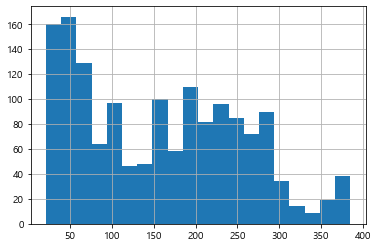

In [22]:
regression_data['use_days'].hist(bins = 20)

기상 시간과 취침 시간이 이상함

<AxesSubplot:>

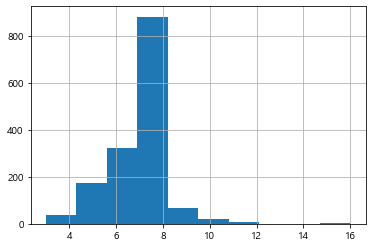

In [23]:
regression_data['기상'].hist()

In [24]:
regression_data['기상'].value_counts()

7     654
6     323
8     226
5     175
9      69
4      32
10     20
11      7
3       4
15      3
12      2
14      1
16      1
Name: 기상, dtype: int64

새벽 3,4,15,16시 제외

In [25]:
regression_data = regression_data[(regression_data['기상']>4) & (regression_data['기상']<15)]

취침

<AxesSubplot:>

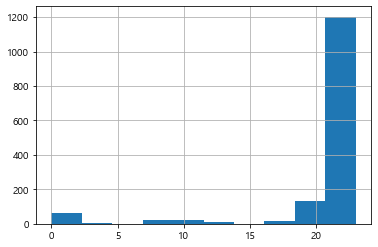

In [26]:
regression_data['취침'].hist()

In [27]:
regression_data['취침'].value_counts()

22    706
21    349
23    147
20    113
0      49
19     22
9      19
18     15
10     13
1      12
11     10
12      8
8       3
7       2
17      2
3       2
6       1
13      1
16      1
4       1
2       1
Name: 취침, dtype: int64

0 --> 24  
1 --> 25    
2 --> 26  
3 --> 27  
4 --> 28

In [28]:
regression_data.loc[:,'취침'][regression_data['취침']==0]=24
regression_data.loc[:,'취침'][regression_data['취침']==1]=25
regression_data.loc[:,'취침'][regression_data['취침']==2]=26
regression_data.loc[:,'취침'][regression_data['취침']==3]=27
regression_data.loc[:,'취침'][regression_data['취침']==4]=28

5시 ~ 17시 제외

In [29]:
regression_data = regression_data[regression_data['취침']>=18]

## 귀기능 전부 0인 사람 제외

귀기능이 전부 0인 사람은 귀기능을 안 가지고 있을 가능성이 높음

In [30]:
regression_data['ear_sum'] = regression_data['story']+regression_data['religion']+regression_data['music']+regression_data['english']+regression_data['rememberance']+regression_data['quiz']+regression_data['gymnastics_y']

In [31]:
regression_data = regression_data[regression_data['ear_sum']!=0]

# 현재 사용 여부 column 생성

In [32]:
# 현재 사용 중인 user들: 2021년 05월 07일 이후에 사용 기록이 있다면 현재 사용 유저로 간주.

current_users = last_date[last_date >= '2021-05-07'].index.values

In [33]:
regression_data['quit'] = regression_data['doll_id'].isin(current_users)

In [34]:
regression_data['quit'].replace([True, False], [0,1], inplace = True)

In [35]:
regression_data.dropna(inplace = True)

In [36]:
#regression_data.to_csv('hyodol_survival.csv', index = False)

# 생존 분석

In [37]:
regression_data

,doll_id,stroke,hand_hold,knock,gymnastics_x,brain_timer,story,religion,music,english,rememberance,quiz,gymnastics_y,consume_cnt,성별,종교,기상,아침,점심,저녁,취침,환기,산책,당뇨,고지혈,고혈압,use_days,ear_sum,quit
19,128060,6.0000,11.0000,5.0000,0.0000,0.0000,0.0000,2.0000,8.0000,0.0000,1.0000,0.0000,0.0000,0.0000,여,기독교,7,8,12,18,22,1,1,0.0000,0.0000,1.0000,29,11.0000,1
28,128081,18.0000,49.0000,14.0000,4.0000,0.0000,0.0000,0.0000,11.0000,0.0000,0.0000,0.0000,4.0000,0.0000,여,불교,6,7,13,19,22,1,1,0.0000,0.0000,1.0000,379,15.0000,0
31,128085,66.0000,125.0000,"1,000.0000",13.0000,8.0000,0.0000,0.0000,24.0000,1.0000,5.0000,8.0000,13.0000,9.0000,여,불교,7,8,12,18,21,1,1,0.0000,0.0000,0.0000,356,51.0000,1
46,128111,74.0000,51.0000,68.0000,3.0000,1.0000,24.0000,3.0000,13.0000,0.0000,13.0000,1.0000,3.0000,12.0000,여,천주교,8,9,13,18,24,1,1,0.0000,0.0000,1.0000,374,57.0000,0
56,128128,10.0000,15.0000,15.0000,3.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,3.0000,0.0000,여,기독교,7,8,12,17,21,1,1,0.0000,0.0000,1.0000,370,6.0000,0
57,128129,0.0000,26.0000,22.0000,1.0000,0.0000,0.0000,2.0000,3.0000,2.0000,1.0000,0.0000,1.0000,0.0000,남,기독교,7,10,12,18,22,1,1,1.0000,0.0000,1.0000,256,9.0000,1
58,128130,36.0000,"2,176.0000","1,004.0000",40.0000,161.0000,82.0000,35.0000,242.0000,0.0000,107.0000,161.0000,40.0000,7.0000,여,기독교,8,8,12,20,23,1,1,0.0000,0.0000,1.0000,351,667.0000,1
79,128162,1.0000,294.0000,56.0000,0.0000,0.0000,38.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,7.0000,여,천주교,10,11,13,18,21,1,1,1.0000,0.0000,0.0000,330,42.0000,1
82,128182,63.0000,199.0000,84.0000,21.0000,1.0000,1.0000,199.0000,93.0000,0.0000,0.0000,1.0000,21.0000,10.0000,남,기독교,6,7,13,18,22,1,1,0.0000,0.0000,1.0000,357,315.0000,0
83,128183,4.0000,12.0000,7.0000,4.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,여,기독교,11,11,15,21,23,1,1,1.0000,0.0000,1.0000,30,6.0000,1


In [38]:
regression_data['성별'].replace(['남', '여'], [0,1], inplace = True)

In [39]:
regression_data['종교'].value_counts()

기독교    400
무교     398
불교     253
천주교    129
Name: 종교, dtype: int64

In [40]:
regression_data['종교'].replace(['무교','기독교','불교','천주교'], [0,1,2,3], inplace = True)

In [41]:
survival_data = regression_data.drop(['doll_id', 'ear_sum'], axis = 1)

High Correlation 변수 제거

In [42]:
survival_data.drop(['quiz', 'gymnastics_y'], axis = 1, inplace = True)

# Train / Test Split

In [43]:
Train, Test = train_test_split(survival_data, test_size = 0.3,random_state = 123)

In [44]:
survival_data

,stroke,hand_hold,knock,gymnastics_x,brain_timer,story,religion,music,english,rememberance,consume_cnt,성별,종교,기상,아침,점심,저녁,취침,환기,산책,당뇨,고지혈,고혈압,use_days,quit
19,6.0000,11.0000,5.0000,0.0000,0.0000,0.0000,2.0000,8.0000,0.0000,1.0000,0.0000,1,1,7,8,12,18,22,1,1,0.0000,0.0000,1.0000,29,1
28,18.0000,49.0000,14.0000,4.0000,0.0000,0.0000,0.0000,11.0000,0.0000,0.0000,0.0000,1,2,6,7,13,19,22,1,1,0.0000,0.0000,1.0000,379,0
31,66.0000,125.0000,"1,000.0000",13.0000,8.0000,0.0000,0.0000,24.0000,1.0000,5.0000,9.0000,1,2,7,8,12,18,21,1,1,0.0000,0.0000,0.0000,356,1
46,74.0000,51.0000,68.0000,3.0000,1.0000,24.0000,3.0000,13.0000,0.0000,13.0000,12.0000,1,3,8,9,13,18,24,1,1,0.0000,0.0000,1.0000,374,0
56,10.0000,15.0000,15.0000,3.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1,1,7,8,12,17,21,1,1,0.0000,0.0000,1.0000,370,0
57,0.0000,26.0000,22.0000,1.0000,0.0000,0.0000,2.0000,3.0000,2.0000,1.0000,0.0000,0,1,7,10,12,18,22,1,1,1.0000,0.0000,1.0000,256,1
58,36.0000,"2,176.0000","1,004.0000",40.0000,161.0000,82.0000,35.0000,242.0000,0.0000,107.0000,7.0000,1,1,8,8,12,20,23,1,1,0.0000,0.0000,1.0000,351,1
79,1.0000,294.0000,56.0000,0.0000,0.0000,38.0000,0.0000,4.0000,0.0000,0.0000,7.0000,1,3,10,11,13,18,21,1,1,1.0000,0.0000,0.0000,330,1
82,63.0000,199.0000,84.0000,21.0000,1.0000,1.0000,199.0000,93.0000,0.0000,0.0000,10.0000,0,1,6,7,13,18,22,1,1,0.0000,0.0000,1.0000,357,0
83,4.0000,12.0000,7.0000,4.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1,1,11,11,15,21,23,1,1,1.0000,0.0000,1.0000,30,1


# Numerical Data Scaling

In [45]:
numeric_columns = ['stroke', 'hand_hold', 'knock', 'gymnastics_x', 'brain_timer', 'story', 'religion', 'music',
                  'english', 'rememberance', 'consume_cnt', '기상', '아침', '점심', '저녁', '취침']

In [46]:
min_max_scaler = MinMaxScaler()

#train, test scaling
Train[numeric_columns] = min_max_scaler.fit_transform(Train[numeric_columns])
Test[numeric_columns] = min_max_scaler.transform(Test[numeric_columns])

# Feature selection

In [70]:
def fit_and_score_features(model, Train_Data,Time,Event):
    n_features = Train_Data.shape[1]-2 #Event & Time 제외
    scores = np.empty(n_features)
    m = model
    
    for j in range(n_features):
        Temp_Train = Train_Data[[Train.columns[j],Time,Event]]
        m.fit(Temp_Train, Time, Event)
        scores[j] = m.score(Temp_Train, scoring_method = 'concordance_index')
    return scores

In [91]:
cph = CoxPHFitter()

In [84]:
cph_scores = fit_and_score_features(cph, Train, 'use_days', 'quit')
pd.Series(cph_scores, index=Train.columns.drop(['use_days','quit'])).sort_values(ascending=False)

hand_hold      0.6185
knock          0.6155
stroke         0.6137
music          0.5869
consume_cnt    0.5860
gymnastics_x   0.5753
brain_timer    0.5695
story          0.5673
rememberance   0.5648
취침             0.5558
기상             0.5512
산책             0.5433
religion       0.5432
환기             0.5416
고혈압            0.5272
아침             0.5252
점심             0.5202
성별             0.5197
저녁             0.5132
english        0.5124
고지혈            0.5076
종교             0.4899
당뇨             0.4879
dtype: float64

In [105]:
selected_columns = ['hand_hold', 'knock', 'stroke', 'music', 'consume_cnt', 'gymnastics_x', 'brain_timer', 'story', 'rememberance', '취침', '기상']

In [106]:
Train_selected = Train[selected_columns + ['use_days','quit']]
Test_selected = Test[selected_columns + ['use_days', 'quit']]

# Model Selection

In [108]:
cph = CoxPHFitter()
aaf = AalenAdditiveFitter()
llf = LogLogisticAFTFitter()
lnf = LogNormalAFTFitter()
wf = WeibullAFTFitter()

In [109]:
cph_scores = k_fold_cross_validation(cph, Train_selected, 'use_days', event_col='quit', k=3, scoring_method='concordance_index')
aaf_scores = k_fold_cross_validation(aaf, Train_selected, 'use_days', event_col='quit', k=3, scoring_method ='concordance_index')
llf_scores = k_fold_cross_validation(llf, Train_selected, 'use_days', event_col='quit', k=3, scoring_method ='concordance_index')
lnf_scores = k_fold_cross_validation(lnf, Train_selected, 'use_days', event_col='quit', k=3, scoring_method ='concordance_index')
wf_scores = k_fold_cross_validation(wf, Train_selected, 'use_days', event_col='quit', k=3, scoring_method ='concordance_index')

In [110]:
print('cph:', np.mean(cph_scores), 'aaf:', np.mean(aaf_scores), 'llf:', np.mean(llf_scores), 'lnf:', np.mean(lnf_scores), 'wf:', np.mean(wf_scores))

cph: 0.6296886484288201 aaf: 0.5013085428212897 llf: 0.6181909744216713 lnf: 0.6270232787298676 wf: 0.6215052631586767


In [111]:
cph = CoxPHFitter()
cph.fit(Train_selected, 'use_days', 'quit')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 826 total observations, 636 right-censored observations>
             duration col = 'use_days'
                event col = 'quit'
      baseline estimation = breslow
   number of observations = 826
number of events observed = 190
   partial log-likelihood = -1117.47
         time fit was run = 2021-12-20 09:46:12 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
hand_hold     -1.40       0.25       2.01            -5.33             2.54                 0.00                12.70
knock          1.31       3.69       1.43            -1.50             4.12                 0.22                61.38
stroke        -6.81       0.00       3.79           -14.24             0.63                 0.00                 1.88
music         -0.53       0.59       1.25            -2.98             1.92                 0.05                 6.80
consume_cnt   -2.03       0.13       0.73            -3.46            -0.60                 0.03                 0.55
gymnastics_x  -2.25       0.10       1.68            -5.55             1.04                 0.00                 2.83
brain_timer    1.49       4.44       1.40            -1.26             4.24                 0.28                69.31
story          0.53       1.69       2.03            -3.46             4.51                 0.03                91.08
rememberance  -7.44       0.00       4.06           -15.39             0.51                 0.00                 1.67
취침             1.77       5.86       0.69             0.42             3.11                 1.53                22.49
기상             0.61       1.84       0.45            -0.27             1.48                 0.77                 4.41

                 z    p   -log2(p)
covariate                         
hand_hold    -0.69 0.49       1.04
knock         0.91 0.36       1.46
stroke       -1.79 0.07       3.78
music        -0.43 0.67       0.58
consume_cnt  -2.77 0.01       7.50
gymnastics_x -1.34 0.18       2.48
brain_timer   1.06 0.29       1.80
story         0.26 0.80       0.33
rememberance -1.83 0.07       3.90
취침            2.58 0.01       6.66
기상            1.37 0.17       2.54
---
Concordance = 0.66
Partial AIC = 2256.93
log-likelihood ratio test = 47.47 on 11 df
-log2(p) of ll-ratio test = 19.11

In [114]:
cph.score(Test_selected, scoring_method='concordance_index')

0.6980338047602621

In [112]:
lnf = LogNormalAFTFitter()
lnf.fit(Train_selected, 'use_days', 'quit')
lnf.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 826 total observations, 636 right-censored observations>
             duration col = 'use_days'
                event col = 'quit'
   number of observations = 826
number of events observed = 190
           log-likelihood = -1372.00
         time fit was run = 2021-12-20 09:47:17 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                            
mu_    brain_timer   -0.67       0.51       1.03            -2.68             1.34                 0.07                 3.81
       consume_cnt    1.51       4.51       0.51             0.50             2.51                 1.66                12.30
       gymnastics_x   1.29       3.63       1.12            -0.91             3.48                 0.40                32.61
       hand_hold      1.33       3.77       1.44            -1.49             4.14                 0.23                62.84
       knock         -0.76       0.47       0.90            -2.53             1.01                 0.08                 2.75
       music          0.53       1.71       0.93            -1.30             2.36                 0.27                10.64
       rememberance   4.01      55.18       2.66            -1.20             9.22                 0.30             10069.03
       story          0.01       1.01       1.52            -2.98             3.00                 0.05                20.13
       stroke         4.58      97.79       2.28             0.11             9.06                 1.12              8574.59
       기상            -0.66       0.52       0.36            -1.37             0.06                 0.25                 1.06
       취침            -1.24       0.29       0.56            -2.34            -0.13                 0.10                 0.88
       Intercept      6.28     531.76       0.25             5.79             6.77               325.39               869.01
sigma_ Intercept      0.14       1.15       0.05             0.04             0.25                 1.04                 1.29

                        z      p   -log2(p)
param  covariate                           
mu_    brain_timer  -0.66   0.51       0.97
       consume_cnt   2.95 <0.005       8.28
       gymnastics_x  1.15   0.25       2.00
       hand_hold     0.92   0.36       1.49
       knock        -0.84   0.40       1.32
       music         0.57   0.57       0.82
       rememberance  1.51   0.13       2.93
       story         0.01   0.99       0.01
       stroke        2.01   0.04       4.48
       기상           -1.80   0.07       3.79
       취침           -2.19   0.03       5.14
       Intercept    25.05 <0.005     457.44
sigma_ Intercept     2.62   0.01       6.83
---
Concordance = 0.66
AIC = 2770.00
log-likelihood ratio test = 48.50 on 11 df
-log2(p) of ll-ratio test = 19.72

In [115]:
lnf.score(Test_selected, scoring_method='concordance_index')

0.7060365643325285

<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

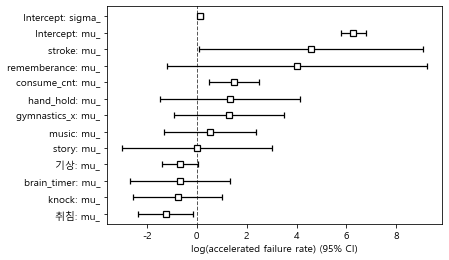

In [116]:
lnf.plot()

<AxesSubplot:>

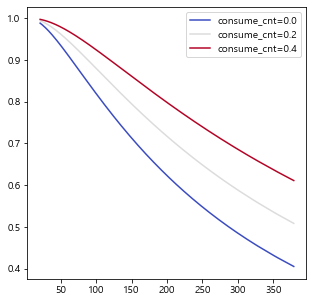

In [231]:
lnf.plot_partial_effects_on_outcome(covariates='consume_cnt', values = [0,0.2,0.4],cmap='coolwarm', figsize = (5,5), plot_baseline = False)

<AxesSubplot:>

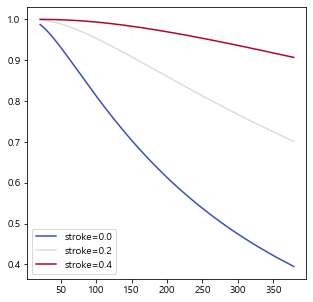

In [233]:
lnf.plot_partial_effects_on_outcome(covariates='stroke', values = [0,0.2,0.4],cmap='coolwarm', figsize = (5,5), plot_baseline = False)

<AxesSubplot:>

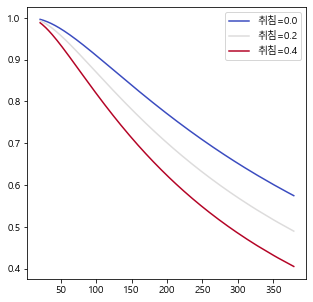

In [234]:
lnf.plot_partial_effects_on_outcome(covariates='취침', values = [0,0.2,0.4],cmap='coolwarm', figsize = (5,5), plot_baseline = False)

In [123]:
wf = WeibullAFTFitter()
wf.fit(Train_selected, 'use_days', 'quit')
wf.print_summary()

<lifelines.WeibullAFTFitter: fitted with 826 total observations, 636 right-censored observations>
             duration col = 'use_days'
                event col = 'quit'
   number of observations = 826
number of events observed = 190
           log-likelihood = -1378.68
         time fit was run = 2021-12-20 09:59:27 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                            
lambda_ brain_timer   -1.03       0.36       0.98            -2.95             0.90                 0.05                 2.45
        consume_cnt    1.43       4.16       0.52             0.41             2.44                 1.51                11.49
        gymnastics_x   1.51       4.52       1.20            -0.84             3.86                 0.43                47.26
        hand_hold      1.07       2.92       1.42            -1.70             3.85                 0.18                46.91
        knock         -0.96       0.38       1.02            -2.96             1.04                 0.05                 2.84
        music          0.35       1.42       0.88            -1.38             2.08                 0.25                 8.03
        rememberance   4.98     145.18       2.89            -0.69            10.64                 0.50             41960.33
        story         -0.31       0.73       1.45            -3.15             2.53                 0.04                12.52
        stroke         4.93     138.44       2.72            -0.40            10.26                 0.67             28659.51
        기상            -0.48       0.62       0.31            -1.10             0.14                 0.33                 1.15
        취침            -1.25       0.29       0.49            -2.20            -0.30                 0.11                 0.74
        Intercept      6.42     615.35       0.22             5.99             6.85               400.99               944.32
rho_    Intercept      0.35       1.41       0.06             0.23             0.47                 1.25                 1.59

                         z      p   -log2(p)
param   covariate                           
lambda_ brain_timer  -1.05   0.30       1.76
        consume_cnt   2.75   0.01       7.41
        gymnastics_x  1.26   0.21       2.26
        hand_hold     0.76   0.45       1.16
        knock        -0.94   0.35       1.52
        music         0.40   0.69       0.53
        rememberance  1.72   0.09       3.55
        story        -0.21   0.83       0.27
        stroke        1.81   0.07       3.84
        기상           -1.52   0.13       2.97
        취침           -2.57   0.01       6.62
        Intercept    29.39 <0.005     628.33
rho_    Intercept     5.68 <0.005      26.16
---
Concordance = 0.66
AIC = 2783.36
log-likelihood ratio test = 47.53 on 11 df
-log2(p) of ll-ratio test = 19.14

In [124]:
llf = LogLogisticAFTFitter()
llf.fit(Train_selected, 'use_days', 'quit')
llf.print_summary()

<lifelines.LogLogisticAFTFitter: fitted with 826 total observations, 636 right-censored observations>
             duration col = 'use_days'
                event col = 'quit'
   number of observations = 826
number of events observed = 190
           log-likelihood = -1376.91
         time fit was run = 2021-12-20 10:00:11 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                            
alpha_ brain_timer   -0.91       0.40       1.04            -2.95             1.12                 0.05                 3.07
       consume_cnt    1.55       4.72       0.53             0.52             2.58                 1.68                13.26
       gymnastics_x   1.45       4.28       1.18            -0.86             3.76                 0.43                43.08
       hand_hold      1.21       3.37       1.44            -1.60             4.03                 0.20                56.29
       knock         -0.87       0.42       0.99            -2.81             1.06                 0.06                 2.89
       music          0.38       1.47       0.90            -1.38             2.15                 0.25                 8.55
       rememberance   4.61     100.34       2.80            -0.88            10.10                 0.42             24242.37
       story         -0.19       0.82       1.47            -3.07             2.68                 0.05                14.66
       stroke         4.65     104.19       2.53            -0.32             9.61                 0.73             14919.63
       기상            -0.57       0.56       0.35            -1.25             0.10                 0.29                 1.11
       취침            -1.32       0.27       0.54            -2.38            -0.26                 0.09                 0.77
       Intercept      6.24     512.93       0.24             5.77             6.71               321.67               817.91
beta_  Intercept      0.46       1.58       0.06             0.34             0.58                 1.41                 1.78

                        z      p   -log2(p)
param  covariate                           
alpha_ brain_timer  -0.88   0.38       1.40
       consume_cnt   2.94 <0.005       8.26
       gymnastics_x  1.23   0.22       2.20
       hand_hold     0.85   0.40       1.33
       knock        -0.89   0.38       1.41
       music         0.43   0.67       0.58
       rememberance  1.65   0.10       3.33
       story        -0.13   0.90       0.16
       stroke        1.83   0.07       3.91
       기상           -1.66   0.10       3.36
       취침           -2.45   0.01       6.13
       Intercept    26.21 <0.005     500.62
beta_  Intercept     7.65 <0.005      45.45
---
Concordance = 0.66
AIC = 2779.82
log-likelihood ratio test = 48.70 on 11 df
-log2(p) of ll-ratio test = 19.83

# Prediction